### 1. Read in the enriched PartB data for year 2013 & 2014

In [1]:
import pandas as pd
import numpy as np
import sklearn
import random
import cloudpickle
import os 
import warnings
warnings.filterwarnings('ignore')

parent = os.path.dirname(os.getcwd())
df = pd.read_csv(parent + '/Capstone_project/data/year2013_2014_combined_with_labels.csv')
df.fillna(0, inplace=True)

print(sum(df.Fraud_Indicator ==1))

df['Rndrng_Prvdr_Type'] = df['Rndrng_Prvdr_Type'].astype('category').cat.codes
df['Rndrng_Prvdr_Gndr'] = df['Rndrng_Prvdr_Gndr'].astype('category').cat.codes
df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'] = df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'].astype('category').cat.codes

print(df.shape)

2550
(1847558, 89)


### 2. Split the data to a train set (used for cross validation) and a test set (holdout)

In [2]:
# split out the holdout data by Rndrng_NPI to avoid data leakage
random.seed(42)
holdout_rate = 0.1

uniq_id = df.Rndrng_NPI.unique()
holdout_set = random.sample(list(uniq_id), int(len(uniq_id)*holdout_rate))
train_set = list(set(uniq_id) - set(holdout_set))

train=df.query("`Rndrng_NPI` in @train_set")
holdout=df.query("`Rndrng_NPI` in @holdout_set")

train_X = train.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
train_y = train.Fraud_Indicator

test_X = holdout.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
test_y = holdout.Fraud_Indicator

print(train_X.shape, test_X.shape)

(1662708, 86) (184850, 86)


### 3. Build up a pipeline including evaluation

In [4]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# define pipeline
def Xgboost_roc_auc_eval(undersample_rate= None, weight = None):
    
    xgb = XGBClassifier(seed = 42, nthread=-1, scale_pos_weight=weight)
    
    if undersample_rate == None:
        steps = [('scaler', StandardScaler()),
                 ('xgb', xgb)]
        
    elif undersample_rate != None:
        under = RandomUnderSampler(sampling_strategy=undersample_rate, random_state =42)
        steps = [('under', under), 
                 ('scaler', StandardScaler()),
                 ('xgb', xgb)]     

        
    pipeline = Pipeline(steps=steps)

    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

    param_grid = {'xgb__max_depth':[2, 5, 10, 20, 50, 100],
                  'xgb__n_estimators':[500],
                  'xgb__learning_rate': [0.01, 0.02, 0.05, 0.1],
                  'xgb__colsample_bytree': [0.5, 0.8, 1],
                  'xgb__colsample_bylevel': [0.5, 0.8, 1],
                  'xgb__subsample': [0.5, 0.8, 1],
                  }

    
    grid_pipe = GridSearchCV(estimator = pipeline, 
                             param_grid = param_grid, 
                             scoring= 'roc_auc', 
                             n_jobs =-1,
                             cv = skf,
                             verbose = 1)
    
    grid_result = grid_pipe.fit(train_X, train_y)
    print('Best Score: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)
    

    scores = cross_val_score(grid_result.best_estimator_, train_X, train_y, scoring = 'roc_auc', cv=skf, n_jobs=-1)
    print('Mean ROC AUC: %.3f' % np.mean(scores), 
          'SD ROC AUC: %.4f' % np.std(scores))
    
    val_auc = roc_auc_score(test_y, grid_result.best_estimator_.predict_proba(test_X)[:, 1])
    print('Test set ROC AUC  %.3f' % val_auc)
    return round(np.mean(scores), 4), round(np.std(scores), 5), round(val_auc, 4), grid_result.best_estimator_

def plot_confusion_matrix(estimator, test_X, test_y):
    # Create the NumPy array for actual and predicted labels.
    actual    = test_y
    predicted = estimator.predict(test_X)

    # compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)

    # Plot the confusion matrix.
    sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=['Non-Fraud','Fraud'],
                yticklabels=['Non-Fraud','Fraud'])
    plt.ylabel('Actual',fontsize=15)
    plt.xlabel('Prediction',fontsize=15)
    plt.title('Confusion Matrix', fontsize=17)
    return plt.show()

In [5]:
# undersample the majority/minority labels to ratio 10:1
xgb_1 = Xgboost_roc_auc_eval(0.1, 10)
print(xgb_1[:3])
xgb_pipe1 = xgb_1[3]
plot_confusion_matrix(xgb_pipe1, test_X, test_y)

cloudpickle.dump(xgb_pipe1, open('xgb_pipe1.cloudpickle','wb'))

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Score:  0.8883425543771948
Best Params:  {'xgb__colsample_bylevel': 0.8, 'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 20, 'xgb__n_estimators': 500, 'xgb__subsample': 0.8}
Mean ROC AUC: 0.888 SD ROC AUC: 0.0076
Test set ROC AUC  0.813
(0.8883, 0.00757, 0.8128)


TypeError: plot_confusion_matrix() missing 2 required positional arguments: 'test_X' and 'test_y'

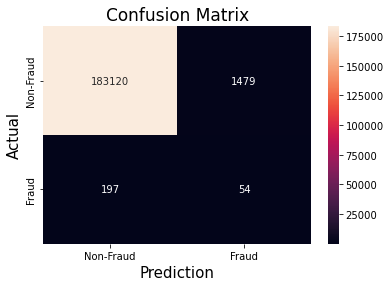

In [6]:
plot_confusion_matrix(xgb_pipe1, test_X, test_y)

cloudpickle.dump(xgb_pipe1, open('xgb_pipe1.cloudpickle','wb'))

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Score:  0.8815193117770438
Best Params:  {'xgb__colsample_bylevel': 0.8, 'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.02, 'xgb__max_depth': 20, 'xgb__n_estimators': 500, 'xgb__subsample': 0.8}
Mean ROC AUC: 0.882 SD ROC AUC: 0.0062
Test set ROC AUC  0.813
(0.8815, 0.00625, 0.8128)


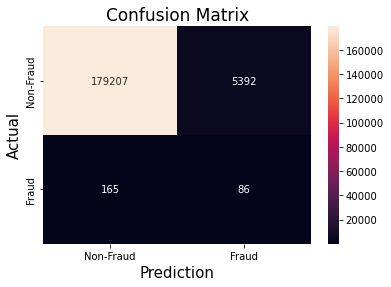

In [7]:
# undersample the majority/minority labels to ratio 4:1 (80:20)
xgb_2 = Xgboost_roc_auc_eval(0.25, 4)
print(xgb_2[:3])
xgb_pipe2 = xgb_2[3]
plot_confusion_matrix(xgb_pipe2, test_X, test_y)

cloudpickle.dump(xgb_pipe2, open('xgb_pipe2.cloudpickle','wb'))

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Score:  0.8731405061173202
Best Params:  {'xgb__colsample_bylevel': 0.8, 'xgb__colsample_bytree': 0.5, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 20, 'xgb__n_estimators': 500, 'xgb__subsample': 0.8}
Mean ROC AUC: 0.873 SD ROC AUC: 0.0051
Test set ROC AUC  0.822
(0.8731, 0.00513, 0.822)


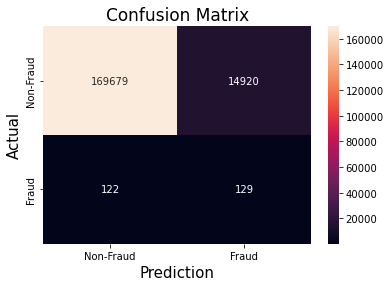

In [8]:
# undersample the majority/minority labels to ratio 2:1
xgb_3 = Xgboost_roc_auc_eval(0.5, 2)
print(xgb_3[:3])
xgb_pipe3 = xgb_3[3]
plot_confusion_matrix(xgb_pipe3, test_X, test_y)

cloudpickle.dump(xgb_pipe3, open('xgb_pipe3.cloudpickle','wb'))

In [ ]:
# undersample the majority/minority labels to ratio 1:1
xgb_4 = Xgboost_roc_auc_eval(1, 1)
print(xgb_4[:3])
xgb_pipe4 = xgb_4[3]
plot_confusion_matrix(xgb_pipe4, test_X, test_y)

cloudpickle.dump(xgb_pipe4, open('xgb_pipe4.cloudpickle','wb'))

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
